In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import preprocessing


### handle 資料


In [22]:

# Load the CSV file into a DataFrame
df = pd.read_csv('ds_clean/ds_clean.csv')
df

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,10,2024-03-01 17:14:06,0.0,1017.48,15.59,94.30,652.92,0.12
1,10,2024-03-01 17:14:47,0.0,1017.48,15.66,94.04,682.50,0.12
2,10,2024-03-01 17:15:47,0.0,1017.47,15.74,94.10,750.00,0.14
3,10,2024-03-01 17:16:47,0.0,1017.46,15.78,94.09,738.33,0.14
4,10,2024-03-01 17:17:47,0.0,1017.49,15.80,94.08,660.83,0.12
...,...,...,...,...,...,...,...,...
1194888,9,2024-07-23 15:50:57,0.0,994.54,30.69,72.91,2288.33,1.10
1194889,9,2024-07-23 15:51:57,0.0,994.40,30.27,73.16,3236.67,1.92
1194890,9,2024-07-23 15:52:57,0.0,994.39,29.90,72.51,4526.67,3.57
1194891,9,2024-07-23 15:53:57,0.0,994.40,29.38,73.23,4231.67,3.13


#### 把資料的時間改成從某點開始算的方式

In [23]:
# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract the date part and calculate the day of the year
df['DayOfYear'] = df['DateTime'].dt.dayofyear
# Calculate the number of minutes since the start of the day
df['MinutesSinceStartOfDay'] = df['DateTime'].dt.hour * 60 + df['DateTime'].dt.minute
# Display the updated DataFrame
df = df.drop(columns=['DateTime'])
df

,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),DayOfYear,MinutesSinceStartOfDay
0,10,0.0,1017.48,15.59,94.30,652.92,0.12,61,1034
1,10,0.0,1017.48,15.66,94.04,682.50,0.12,61,1034
2,10,0.0,1017.47,15.74,94.10,750.00,0.14,61,1035
3,10,0.0,1017.46,15.78,94.09,738.33,0.14,61,1036
4,10,0.0,1017.49,15.80,94.08,660.83,0.12,61,1037
...,...,...,...,...,...,...,...,...,...
1194888,9,0.0,994.54,30.69,72.91,2288.33,1.10,205,950
1194889,9,0.0,994.40,30.27,73.16,3236.67,1.92,205,951
1194890,9,0.0,994.39,29.90,72.51,4526.67,3.57,205,952
1194891,9,0.0,994.40,29.38,73.23,4231.67,3.13,205,953


In [24]:
unique_day_minute_combinations = df[['DayOfYear', 'MinutesSinceStartOfDay']].drop_duplicates()
num_unique_combinations = unique_day_minute_combinations.shape[0]
print(f"Number of unique (day, minute) combinations: {num_unique_combinations}")
# Number of unique (day, minute) combinations: 135606

Number of unique (day, minute) combinations: 167998


### 評估資料缺失狀況



In [25]:
# 複製一份 unique_day_minute_combinations 叫做 missing
missing = unique_day_minute_combinations.copy()

# 將 df 過濾為只包含必要的行
filtered_df = df[df['LocationCode'].isin([1, 2, 3])]

# 透過 groupby 聚合來檢查每組 (DayOfYear, MinutesSinceStartOfDay) 是否涵蓋所有 location
location_check = (
    filtered_df.groupby(['DayOfYear', 'MinutesSinceStartOfDay'])['LocationCode']
    .nunique()
    .reset_index()
)

# 篩選出 location 不完整的 (DayOfYear, MinutesSinceStartOfDay)
incomplete_combinations = location_check[location_check['LocationCode'] < 3]
incomplete_combinations = incomplete_combinations[['DayOfYear', 'MinutesSinceStartOfDay']]

# 將 missing 限制為不完整的組合
missing = missing.merge(incomplete_combinations, on=['DayOfYear', 'MinutesSinceStartOfDay'], how='inner')

# 顯示結果
missing


,DayOfYear,MinutesSinceStartOfDay
0,61,1034
1,61,1035
2,61,1036
3,61,1037
4,61,1038
...,...,...
118402,155,293
118403,155,294
118404,156,1129
118405,170,1137


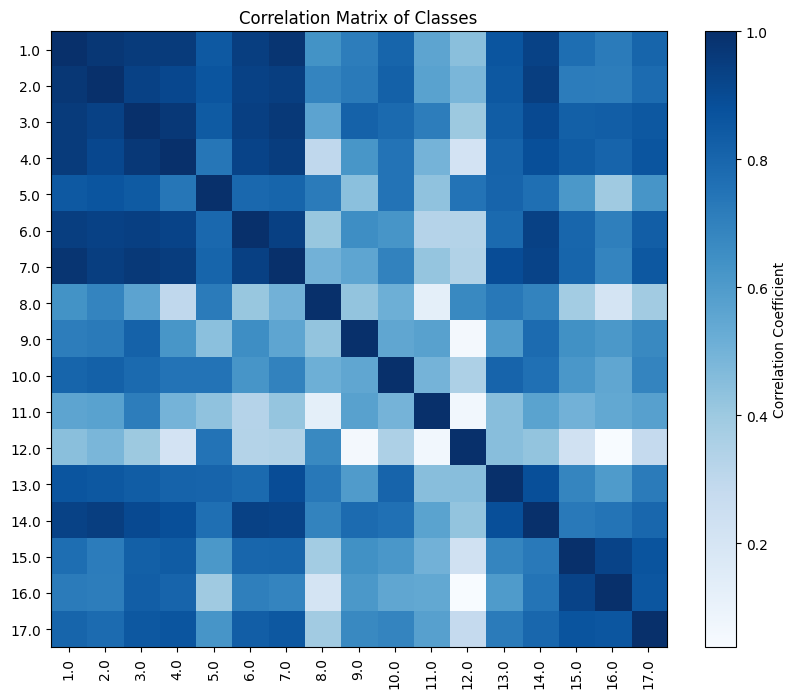

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設原始數據
data = df[['LocationCode', 'DayOfYear', 'MinutesSinceStartOfDay', 'Sunlight(Lux)']]

# 建立 DataFrame
class_data = pd.DataFrame(data)

# Step 1: 建立統一時間戳記欄位
class_data['timestamp'] = class_data['DayOfYear'] * 24 * 60 + class_data['MinutesSinceStartOfDay']  # 轉換成分鐘為基準的時間戳
class_data = class_data[['LocationCode', 'timestamp', 'Sunlight(Lux)']]  # 保留需要的欄位

# Step 2: 建立完整時間範圍並對齊
full_time_range = pd.DataFrame({'timestamp': np.arange(class_data['timestamp'].min(), class_data['timestamp'].max() + 1)})
merged = full_time_range.merge(class_data, on='timestamp', how='left')

# 將不同的 class 分成獨立欄位
pivot_table = merged.pivot_table(index='timestamp', columns='LocationCode', values='Sunlight(Lux)')

# Step 3: 計算相關性
correlation_matrix = pivot_table.corr(method='pearson')

# Step 4: 視覺化相關性
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Correlation Matrix of Classes')
plt.show()


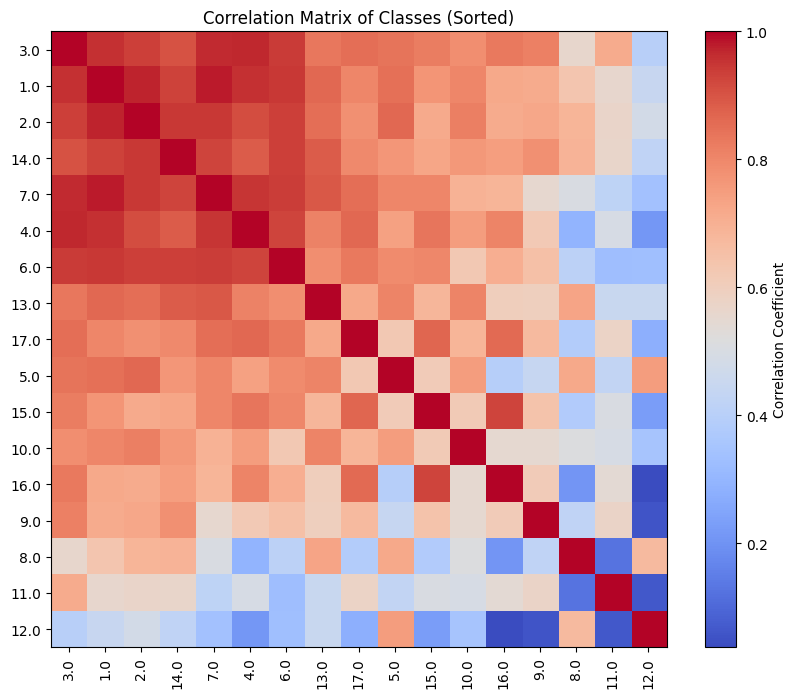

In [38]:
# Step 4: 根據平均相關性排序
mean_correlation = correlation_matrix.mean(axis=1).sort_values(ascending=False)
sorted_classes = mean_correlation.index
sorted_matrix = correlation_matrix.loc[sorted_classes, sorted_classes]

# Step 5: 視覺化相關性
plt.figure(figsize=(10, 8))
plt.imshow(sorted_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(sorted_matrix.columns)), sorted_matrix.columns, rotation=90)
plt.yticks(range(len(sorted_matrix.index)), sorted_matrix.index)
plt.title('Correlation Matrix of Classes (Sorted)')
plt.show()

#### 策略
因為目前看起來是要找同時間的周遭測站的狀況去推估發電情形(不然就變成是猜天氣)
所以應該會需要先過濾出能train的資料